Import Of The Important Libraries Required for Solving This Problem.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string 
import re
from nltk.corpus import stopwords
from collections import Counter
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import graphviz
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
os.listdir()

['Untitled.ipynb',
 'model.png',
 '.ipynb_checkpoints',
 'negative.txt',
 'Sentiment_Analysis_Udacity.ipynb',
 'txt_sentoken',
 'vocab.txt',
 'review_polarity',
 'positive.txt']

# Preprocessing Step 
# Import Data

In [3]:
# Function to load document into the notebook
def load_document(fileName):
    file=open(fileName,'r')
    text_data=file.read()
    file.close()
    return text_data

In [4]:
# Data Cleaning Step
# Turn a document into tokens after processing it.

def clean_document(document):
    #split the review into tokens by white space
    tokens=document.split()
    # regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # removetokens which are not alphabetis
    tokens = [word for word in tokens if word.isalpha()]
    # remove stop words
    ##  A stop word is a commonly used word (such as “the”, “a”, “an”, “in”)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # remove out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    
    return tokens

In [5]:
filename="txt_sentoken/pos/cv001_18431.txt"
text=load_document(filename)
tokens=clean_document(text)
print(tokens[:10])

['every', 'movie', 'comes', 'along', 'suspect', 'studio', 'every', 'indication', 'stinker', 'everybodys']


In [6]:
# Function to save list to file
def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [7]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

In [8]:
# directory='txt_sentoken/neg'
# for file in os.listdir(directory):
#     if file.endswith(".txt"):
#         doc=load_document(directory+'/'+file)
#         print("Loaded Document %s" % file)

# Develop Vocabulary

In [9]:
# Function to Load Document and then add the words to Vocab
def document_to_vocabulary(fileName,vocab):
    document=load_document(fileName)
    tokens=clean_document(document)
    vocab.update(tokens)

In [10]:
# Function to Process All the documents in the Directory
def process_documents(directory, vocab):
    count=0
    for fileName in os.listdir(directory):
        if fileName.endswith(".txt"):
            path=directory+"/"+fileName
            document_to_vocabulary(path,vocab)
            count+=1
    print("Total Number Of Files Processed In {d} = {n}".format(d=directory,n=count))

In [11]:
# Main Function To Process the documents 
# Global Varaible To Store The Count 

vocab = Counter()

def develop_vocab():
    global vocab
#     vocab= Counter()
    process_documents('txt_sentoken/neg', vocab)
    process_documents('txt_sentoken/pos', vocab)
    
    
    min_occur = 5
    
    tokens = [k for k,c in vocab.items() if c >= min_occur]
    save_list(tokens,"vocab.txt")

develop_vocab()

Total Number Of Files Processed In txt_sentoken/neg = 1000
Total Number Of Files Processed In txt_sentoken/pos = 1000


In [12]:
#Check Whether The File is Create or not 
if "vocab.txt" in os.listdir():
    print("TRUE")

TRUE


In [13]:
#print Length of the Vocabulary
print("Total Length Of The Vocabulary %s" %len(vocab))

Total Length Of The Vocabulary 46557


In [14]:
# 50 Most Common Words
print(vocab.most_common(50))

[('film', 8860), ('one', 5521), ('movie', 5440), ('like', 3553), ('even', 2555), ('good', 2320), ('time', 2283), ('story', 2118), ('films', 2102), ('would', 2042), ('much', 2024), ('also', 1965), ('characters', 1947), ('get', 1921), ('character', 1906), ('two', 1825), ('first', 1768), ('see', 1730), ('well', 1694), ('way', 1668), ('make', 1590), ('really', 1563), ('little', 1491), ('life', 1472), ('plot', 1451), ('people', 1420), ('movies', 1416), ('could', 1395), ('bad', 1374), ('scene', 1373), ('never', 1364), ('best', 1301), ('new', 1277), ('many', 1268), ('doesnt', 1267), ('man', 1266), ('scenes', 1265), ('dont', 1210), ('know', 1207), ('hes', 1150), ('great', 1141), ('another', 1111), ('love', 1089), ('action', 1078), ('go', 1075), ('us', 1065), ('director', 1056), ('something', 1048), ('end', 1047), ('still', 1038)]


# Top Ten Most Common Words

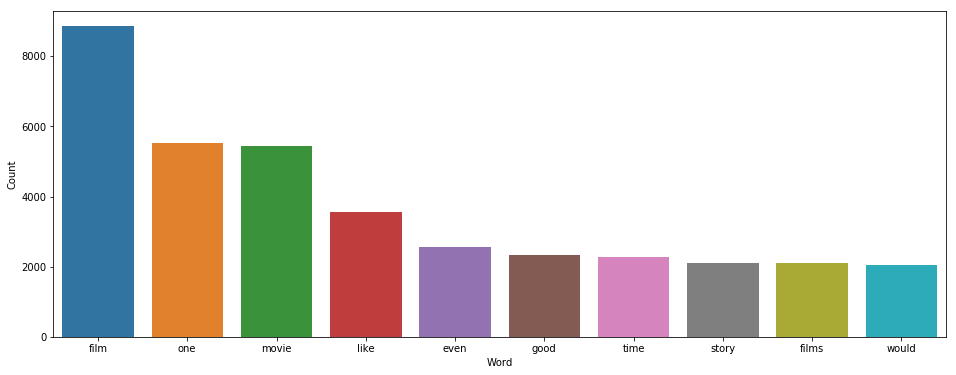

In [15]:
vocabmcdf=pd.DataFrame(data=vocab.most_common(10),columns=['Word','Count'])
plt.figure(figsize=(16,6))
sns.barplot(x='Word',y="Count",data=vocabmcdf)

In [16]:
#Load The Vocabulary from Vocab.txt File.

vocab_data=load_document("vocab.txt")
vocab_data=vocab_data.split()
vocab=set(vocab_data)
print("Number of Words in Vocab.txt is %s" %len(vocab))

Number of Words in Vocab.txt is 14803


# Prepare Review For Modeling

Creating Negative.txt and Positive.txt from all the review documents.

In [17]:
def process_review_documents(directory,vocab,train=False,op=0):
    lines=[]
    count=0
    for file in os.listdir(directory):
#         print(file)

        if file.endswith(".txt"):
            if not op:
                if train and file.startswith("cv9"):
                    continue
                if not train and not file.startswith("cv9"):
                    continue
            count+=1
            file_path=directory + '/' + file
            lines_in_file=load_document(file_path)
            tokens=clean_document(lines_in_file)
            tokens=[w for w in tokens if w in vocab]
            line=' '.join(tokens)
        lines.append(line)
#         print(lines)
    print("Number of File Processed in {d} is {n}".format(d=directory,n=count))
    return lines

# Negative lines from all the documents from "txt_sentoken/neg"

In [18]:
# Negative lines from all the documents from "txt_sentoken/neg"
neg_lines=process_review_documents("txt_sentoken/neg",vocab_data,op=1)
save_list(neg_lines,"negative.txt")

#Load Negative Lines From negative.txt
negative_lines=load_document("negative.txt")
print("Length of the Negative.txt File is %s " %len(negative_lines))


Number of File Processed in txt_sentoken/neg is 1000
Length of the Negative.txt File is 2124581 


In [19]:
print(negative_lines[:100])

studio attracted many weird bizarre people gates wonder film life death studio centers one boring cl


# Positive lines from all the documents from "txt_sentoken/pos"

In [20]:
# Negative lines from all the documents from "txt_sentoken/neg"
pos_lines=process_review_documents("txt_sentoken/pos",vocab_data,op=1)
save_list(pos_lines,"positive.txt")

#Load Negative Lines From negative.txr
positive_lines=load_document("positive.txt")
print("Length of the Positive.txt File is %s " %len(positive_lines))


Number of File Processed in txt_sentoken/pos is 1000
Length of the Positive.txt File is 2408780 


In [21]:
print(positive_lines[:100])

david lynchs blue velvet begins ends colorful bright shots flowers happy americans seemingly perfect


In [22]:
def load_clean_dataset(vocab,train=False):
    neg=process_review_documents('txt_sentoken/neg', vocab,train)
    pos=process_review_documents('txt_sentoken/pos', vocab,train)
    docs=neg+pos
    print("Length of   Negative Files = {n} \t Positive Files= {p} \t Doc = {d} ".format(n=len(neg),p=len(pos),d=len(docs)))
    labels =[0 for i in range(len(neg))] + [1 for j in range(len(pos))]
    return docs,labels
    

# Train Test Split

Dividing 90% 10% Ration 1000 Review Document

# Load Training DataSet

In [23]:
# load all training reviews
train_docs, ytrain = load_clean_dataset(vocab,train=True)


Number of File Processed in txt_sentoken/neg is 900
Number of File Processed in txt_sentoken/pos is 900
Length of   Negative Files = 900 	 Positive Files= 900 	 Doc = 1800 


In [24]:
print(len(train_docs))

1800


In [25]:
print(len(ytrain))

1800


# Load Test DataSet

In [26]:
test_docs, ytest = load_clean_dataset(vocab)

Number of File Processed in txt_sentoken/neg is 100
Number of File Processed in txt_sentoken/pos is 100
Length of   Negative Files = 100 	 Positive Files= 100 	 Doc = 200 


# Keras Tokenizer To Implement Bag Of Words

In [27]:
# Function To Tokenize
def create_tokenizer(lines):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [28]:
# create the tokenizer
tokenizer = create_tokenizer(train_docs)

In [29]:
# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')
print(Xtrain.shape, Xtest.shape)

(1800, 14781) (200, 14781)


# Benchmark Model

In [30]:
n_words=Xtest.shape[1]
n_words

14781

In [31]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [32]:
#fit network
model=define_model(n_words)
model.fit(Xtrain, ytrain, epochs=10, verbose=2)


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                739100    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 739,151
Trainable params: 739,151
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 1s - loss: 0.6922 - acc: 0.5667
Epoch 2/10
 - 1s - loss: 0.6851 - acc: 0.6983
Epoch 3/10
 - 1s - loss: 0.6690 - acc: 0.7639
Epoch 4/10
 - 1s - loss: 0.6429 - acc: 0.8917
Epoch 5/10
 - 1s - loss: 0.6077 - acc: 0.9222
Epoch 6/10
 - 1s - loss: 0.5669 - acc: 0.9278
Epoch 7/10
 - 1s - loss: 0.5215 - acc: 0.9328
Epoch 8/10
 - 1s - loss: 0.4773 - acc: 0.9383
Epoch 9/10
 - 1s - loss: 0.4342 - acc: 0.947

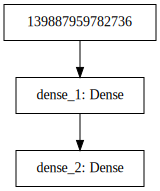

In [33]:
#Plot of The Defined model
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [34]:
# evaluate
loss, acc  = model.evaluate(Xtest, ytest, verbose=0)
print('Test Loss: %f' % (loss*100))
print('Test Accuracy: %f' % (acc*100))

Test Loss: 48.480350
Test Accuracy: 88.000000


# Predicting Sentiment For Reviews


In [35]:
def predict_sentiment(review, vocab, tokenizer, model):
    tokens = clean_document(review)
    tokens = [w for w in tokens if w in vocab]
    line = ' '.join(tokens)
    # encode
    encoded = tokenizer.texts_to_matrix([line], mode='freq')
    # predict sentiment
    yhat = model.predict(encoded, verbose=0)
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [56]:
text = 'Best movie ever! It was great, I recommend it.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s ' % (text, sentiment))
# test negative text

text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s ' % (text, sentiment))

text = 'An above average one for one time watch.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s ' % (text, sentiment))


text = "Very heart touching and making us proud movie. The acting done \
by akshay Kumar is awesome in the movie.   \
The whole theater was emotional at the end of the movie."

percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s ' % (text, sentiment))

text = "one Of the Best Movie evar made in Bollywood on War What a wonderful \
Location and Sets Akshay Kumar Naild it Again and proven again that why He is king Of the Bollywood"
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s ' % (text, sentiment))

Review: [Best movie ever! It was great, I recommend it.]
Sentiment: POSITIVE 
Review: [This is a bad movie.]
Sentiment: NEGATIVE 
Review: [An above average one for one time watch.]
Sentiment: POSITIVE 
Review: [Very heart touching and making us proud movie. The acting done by akshay Kumar is awesome in the movie.   The whole theater was emotional at the end of the movie.]
Sentiment: NEGATIVE 
Review: [one Of the Best Movie evar made in Bollywood on War What a wonderful Location and Sets Akshay Kumar Naild it Again and proven again that why He is king Of the Bollywood]
Sentiment: POSITIVE 


# Compare Word Scoring 

In [35]:

modes= ['binary', 'count', 'tfidf', 'freq']
#Prepare Bag - Of - Words Encoding
results=pd.DataFrame()
def prepare_data(train,test,m):
    token=Tokenizer()
    token.fit_on_texts(train)
    Xtrain=token.texts_to_matrix(train, mode=mode)
    Xtest = token.texts_to_matrix(test, mode=mode)
    return Xtrain,Xtest

#Evaluate
def evaluate_mode(Xtrain,ytrain,Xtest,ytest):
    scores=list()
    no_r=10
    for _ in range(no_r):
        model=Sequential() 
        model.add(Dense(50,input_shape=(n_words,),activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
        model.fit(Xtrain,ytrain,epochs=10,verbose=1)
        loss,acc=model.evaluate(Xtest,ytest,verbose=1)
        scores.append(acc)
        print("%d accuracy : %s "%((_+1),acc))
    return scores

for mode in modes:
    Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
    results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)



Epoch 1/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4694 - acc: 0.7794
Epoch 2/10
1800/1800 [==============================] - 2s 875us/step - loss: 0.0562 - acc: 0.9956
Epoch 3/10
1800/1800 [==============================] - 2s 870us/step - loss: 0.0151 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 880us/step - loss: 0.0071 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 859us/step - loss: 0.0040 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 871us/step - loss: 0.0025 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 877us/step - loss: 0.0017 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 880us/step - loss: 0.0013 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 881us/step - loss: 9.4794e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 0s 327us/step
1 accuracy : 0.92 
Epoch 1/10
1800/180

1800/1800 [==============================] - 2s 1ms/step - loss: 0.0015 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 993us/step - loss: 0.0011 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 0s 747us/step
8 accuracy : 0.915 
Epoch 1/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4561 - acc: 0.7883
Epoch 2/10
1800/1800 [==============================] - 3s 2ms/step - loss: 0.0459 - acc: 0.9939A: 0s - loss: 0.04
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0121 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0065 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 3s 2ms/step - loss: 0.0042 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0030 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0022 - acc: 1.0000
Epoch 8/10
1800/1800 [=======

1800/1800 [==============================] - 3s 1ms/step - loss: 0.4690 - acc: 0.7722
Epoch 2/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0184 - acc: 0.9994
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0038 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0016 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0010 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 6.9740e-04 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 5.0353e-04 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 1ms/step - loss: 3.8501e-04 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 1ms/step - loss: 2.9850e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 0s 2ms/step
4 accuracy : 0.88 
Epoch 1/10
1800/1800 [==============

1800/1800 [==============================] - 2s 1ms/step - loss: 0.5609 - acc: 0.8956
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5199 - acc: 0.9417
Epoch 8/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4782 - acc: 0.9567
Epoch 9/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4359 - acc: 0.9650
Epoch 10/10
200/200 [==============================] - 1s 3ms/step
9 accuracy : 0.855 
Epoch 1/10
1800/1800 [==============================] - 4s 2ms/step - loss: 0.6925 - acc: 0.4978
Epoch 2/10
1800/1800 [==============================] - 3s 1ms/step - loss: 0.6872 - acc: 0.6311
Epoch 3/10
1800/1800 [==============================] - 3s 1ms/step - loss: 0.6757 - acc: 0.6578
Epoch 4/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6560 - acc: 0.8261
Epoch 5/10
1800/1800 [==============================] - 3s 1ms/step - loss: 0.6292 - acc: 0.8828
Epoch 6/10
1800/1800 [=============================

          binary      count      tfidf       freq
count  10.000000  10.000000  10.000000  10.000000
mean    0.920000   0.890000   0.867500   0.865000
std     0.008165   0.009718   0.013591   0.007454
min     0.905000   0.875000   0.845000   0.855000
25%     0.916250   0.885000   0.861250   0.861250
50%     0.920000   0.895000   0.872500   0.865000
75%     0.925000   0.895000   0.878750   0.868750
max     0.930000   0.905000   0.880000   0.880000


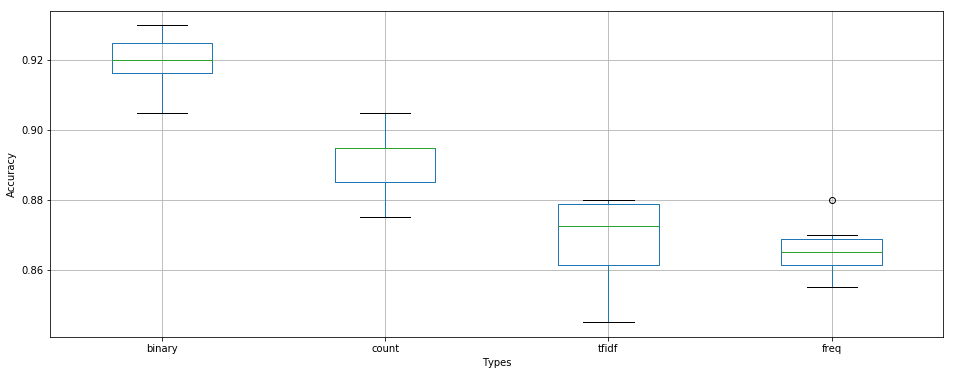

In [39]:
print(results.describe())
plt.figure(figsize=(16,6))
results.boxplot()
plt.xlabel("Types")
plt.ylabel("Accuracy")
plt.show()
